In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
from src.diffusion import Diffusion
from src.unet import UNet
from src.utils import ASL_mnist, show_dataset_images, show_samples, numel

In [3]:
dataset_path = './datasets'
batch_size = 192

image_channels = 1
image_size = 28

In [4]:
if torch.cuda.is_available():
  device = 'cuda'
  print('CUDA')
else:
  device = 'cpu'
  print('CPU')

CUDA


In [5]:
transform = transforms.Compose([
    transforms.Lambda(lambda t: (t/255.)*2. - 1)
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: t.detach().cpu().permute(1, 2, 0).numpy())
])

In [6]:
train_dataset = ASL_mnist(dataset_path, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

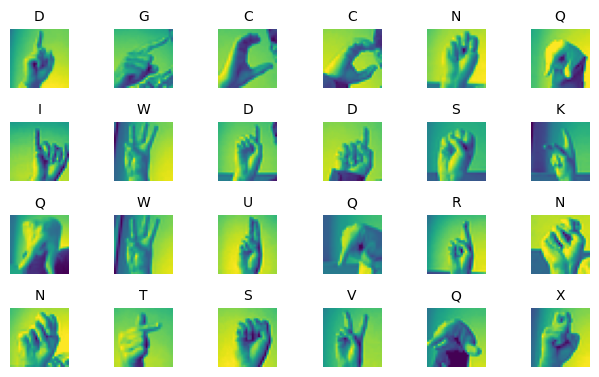

In [7]:
show_dataset_images(train_dataset, reverse_transform)

In [8]:
ddpm_wide = Diffusion(UNet(channel_mults=[8, 16, 24], attention_heads=[None, None, None]), device)
ddpm_attn = Diffusion(UNet(channel_mults=[8, 16, 24], attention_heads=[None, 1, 1]), device)

print(f'Number of trainable parameters in a wide model without attention: {numel(ddpm_wide.model)}')
print(f'Number of trainable parameters in a narrow model with attention: {numel(ddpm_attn.model)}')

Number of trainable parameters in a wide model without attention: 89445
Number of trainable parameters in a narrow model with attention: 97741


In [10]:
import time
from tqdm.auto import tqdm

def train_for_n_epochs(model, data_loader, epochs=1, lr=1e-3):
    start_time = time.time()
    for i in tqdm(range(epochs)):
        if i%20 == 0:
            print(f'result after training for {i} epochs')
            show_samples(model, reverse_transform)
            print("--- %s seconds ---" % (time.time() - start_time))   
        model.diffusion_train_epoch(data_loader, lr=lr)
    print(f'result after training for {epochs} epochs')
    show_samples(model, reverse_transform)
    print("--- %s seconds ---" % (time.time() - start_time))  

  0%|          | 0/5 [00:00<?, ?it/s]

result after training for 0 epochs


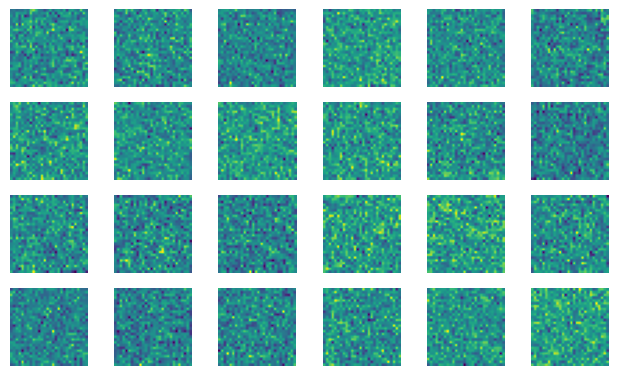

--- 1.5539989471435547 seconds ---
result after training for 5 epochs


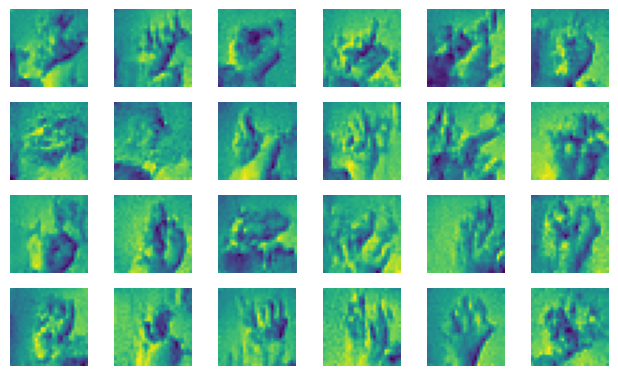

--- 67.64699983596802 seconds ---


  0%|          | 0/5 [00:00<?, ?it/s]

result after training for 0 epochs


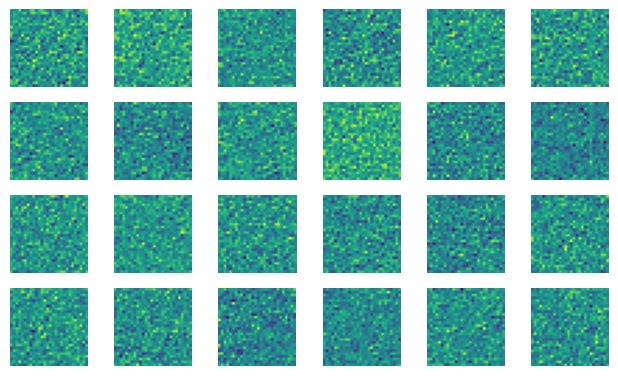

--- 2.268998622894287 seconds ---
result after training for 5 epochs


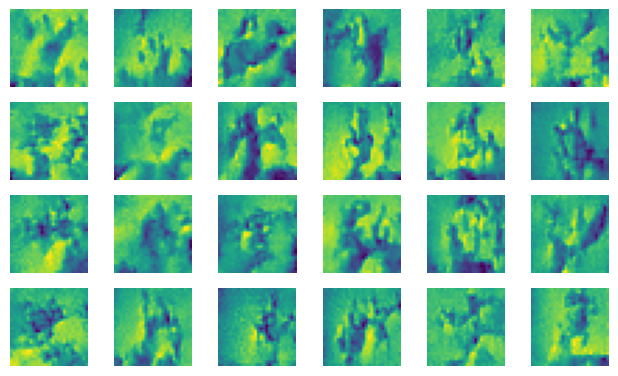

--- 176.67699933052063 seconds ---


In [11]:
train_for_n_epochs(ddpm_wide, train_loader, epochs=5, lr=1e-3)
train_for_n_epochs(ddpm_attn, train_loader, epochs=5, lr=1e-3)

  0%|          | 0/20 [00:00<?, ?it/s]

result after training for 0 epochs


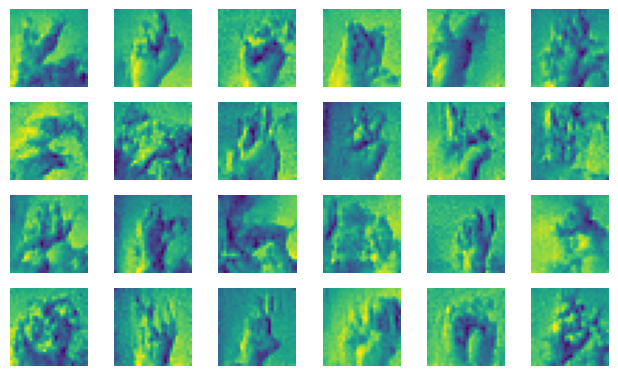

--- 1.1870002746582031 seconds ---
result after training for 20 epochs


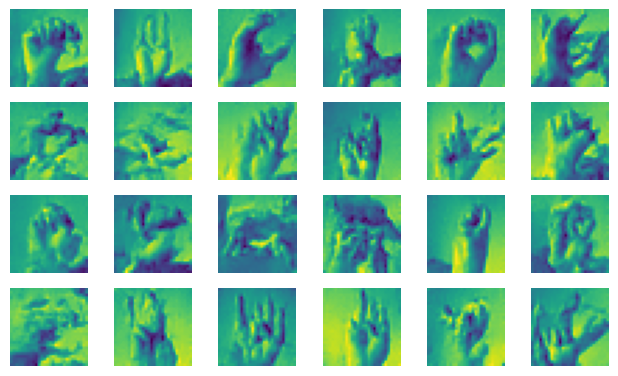

--- 266.6260004043579 seconds ---


  0%|          | 0/20 [00:00<?, ?it/s]

result after training for 0 epochs


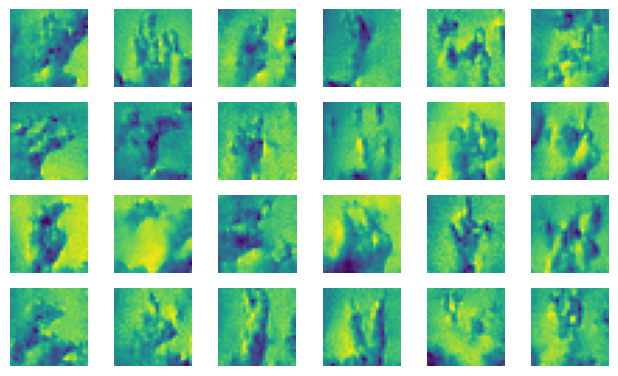

--- 2.28399920463562 seconds ---
result after training for 20 epochs


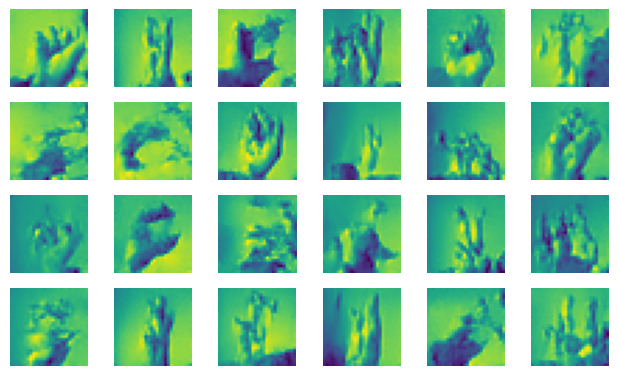

--- 730.6312773227692 seconds ---


In [12]:
train_for_n_epochs(ddpm_wide, train_loader, epochs=20, lr=3e-4)
train_for_n_epochs(ddpm_attn, train_loader, epochs=20, lr=3e-4)

  0%|          | 0/20 [00:00<?, ?it/s]

result after training for 0 epochs


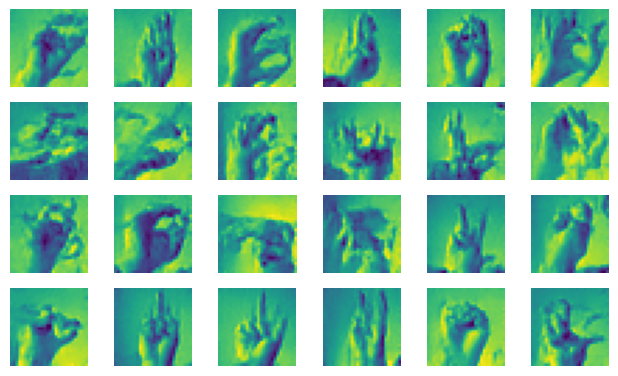

--- 1.3090002536773682 seconds ---
result after training for 20 epochs


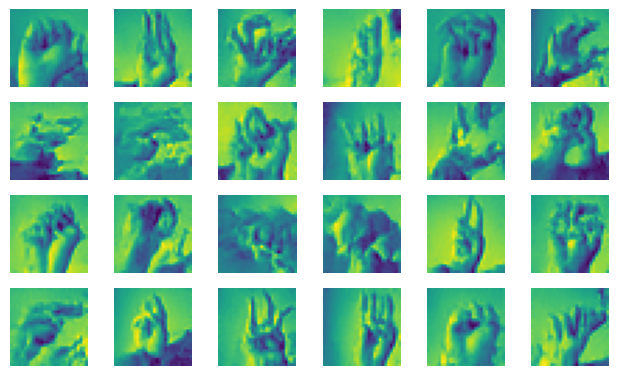

--- 269.8750102519989 seconds ---


  0%|          | 0/20 [00:00<?, ?it/s]

result after training for 0 epochs


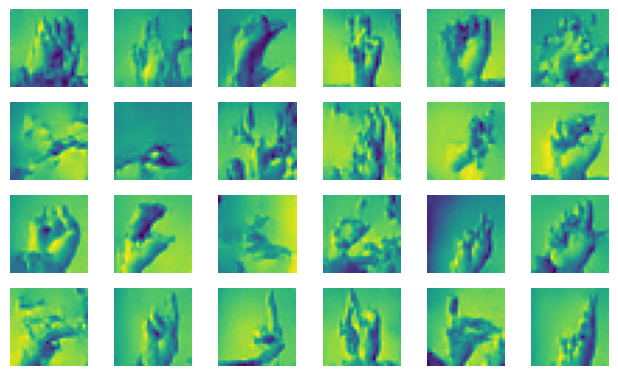

--- 2.2960000038146973 seconds ---
result after training for 20 epochs


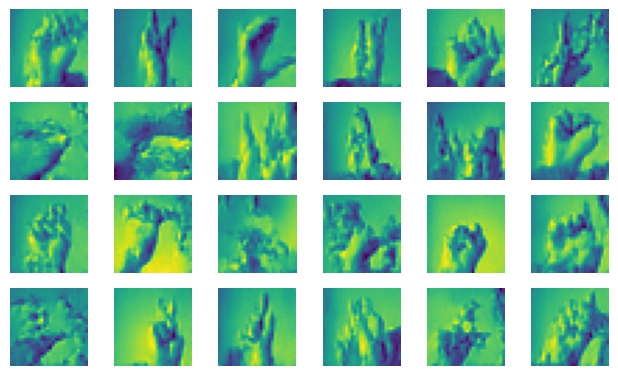

--- 719.896999835968 seconds ---


In [15]:
train_for_n_epochs(ddpm_wide, train_loader, epochs=20, lr=5e-5)
train_for_n_epochs(ddpm_attn, train_loader, epochs=20, lr=5e-5)

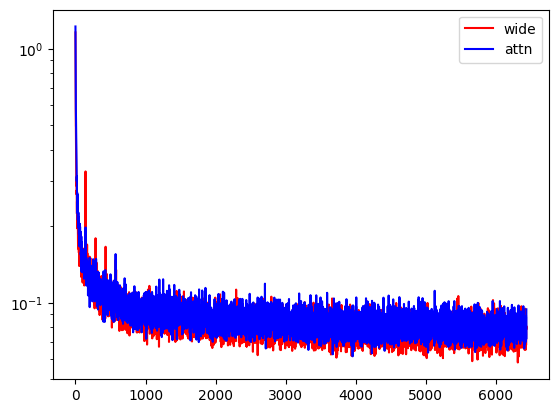

In [17]:
plt.plot(ddpm_wide.results['loss_history'], color='red', label='wide')
plt.plot(ddpm_attn.results['loss_history'], color='blue', label='attn')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
ddpm_wide.save_model_as('wide_model_state')
ddpm_attn.save_model_as('attn_model_state')